# Distracted Driving Prediction
## Deep Learning with python, keras & tensorflow
### Sean O'Malley


The goal of this analysis is to identify the various types of distracted driving scenarios simply using images. We will accomplish this by using deep learning in python with the keras and a tensorflow backend. 

<a href="https://www.kaggle.com/c/state-farm-distracted-driver-detection#description">State Farm Distracted Driving Kaggle Competition</a>

As a contextual reference, deep learning is a subset of machine learning that allows algorithms to train itself in order to perform tasks like image and speech recognition. Deep learning accomplishes this by revealing immense amounts of data to multi-layered neural networks.

__This document will walk you through the entire process of:__ 
* Initiate Google Drive feature in Colaboratory utilize cloud computing power
* Ingest a list of images
* Transform them into something that can be understood by a computer
* Split into test and training groups
* Prepare data to fit into a deep learning model
* Model builds

__The Following Model Types Will Be Built:__
1. Sequential API Convolutional Neural Net
2. Functional API Convolutional Neural Net  _with inception module architecture_ + Kaggle Submission
3. Functional API Convolutional Neural Net  _inception module architecture using BatchNormalization_ + Kaggle Submission
    
I will provide commentary, summary statistics and visualization along the way, to help determine the most successful model to move forward with in identifying distracted driving via images. 

We will conclude with a summary of the strengths, weaknesses and opportunities for improvement in the models to help fully understand the data, the models and the ultimate application of the analysis.

---
## __Package Import__

In [0]:
# Basic Packages
import time
import numpy as np
import pandas as pd
import os, sys

# Deep Learning Packages
from keras.models import Sequential, Model, model_from_json
from keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical, np_utils
from keras import backend as K
from keras.optimizers import Adam, RMSprop
import h5py

# Image Import & View Packages
import glob
import matplotlib.pyplot as plt
from PIL import Image


---
### __Uploading Files From Google Drive into Colaboratory environment__

Much of the data creation is included in this document, however many of the processes after the creation of HDF5 files are actually performed locally, and then I moved the script to the Colaboratory environment where I could take advantage of the increased cloud computing.

In [9]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0

Setting up libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Setting up unattended-upgrades (0.98ubuntu1.1) ...

Creating config file /etc/apt/apt.conf.d/20auto-upgrades with new version

Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up python3-gi (3.24.1-2build1) ...
Setting up module-init-tools (24-1ubuntu2) 

In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [11]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
# Create a folder to use the competition. once this is run there is no longer a need to run again. The directory should be present in the Google Drive
!mkdir -p /content/drive/competition/

In [14]:
!ls /content/drive/competition/ 

Deep_Learning_Distracted_Driving_Image_Recognition.ipynb
sample_submission.csv
sequential_cnn_model.h5
sequential_cnn_model.json
simple_sequential_model_pred.csv
testdata.hdf5
traindata.hdf5


In [0]:
os.chdir('/content/drive/competition/')

In [16]:
!ls

Deep_Learning_Distracted_Driving_Image_Recognition.ipynb
sample_submission.csv
sequential_cnn_model.h5
sequential_cnn_model.json
simple_sequential_model_pred.csv
testdata.hdf5
traindata.hdf5


---
## __Exploratory Data Analysis__

Ingest and view summaries of csv's to help us gain an understanding of the data we have. Looking at the data below, you'll see that we have 10 classes of images, living in separate photos. The photos are already categorized in their predefined classes by folders.

In [0]:
sample_submission = pd.read_csv('sample_submission.csv')

Keep in mind that what we see below will need to be the format we follow for our analysis submission.

In [26]:
sample_submission.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,img_10.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,img_100.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,img_1000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,img_100000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


__Image Characteristics__

We see that the images are jpegs, 640x480 pixels and in full RGB color and that we are in fact attempting to identify distracted driver images. 

JPEG (640, 480) RGB


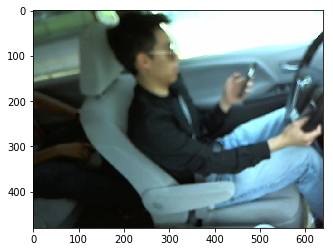

In [0]:
%matplotlib inline

imagetest = Image.open('imgs/test/img_2200.jpg')

print(imagetest.format, imagetest.size, imagetest.mode)

plt.imshow(imagetest)

### __Manipulate and Transform Image Data__


The below outer for loop ingests each image from their respective folders while maintaining the classification of the image.

The nested for loop takes each image, converts it to black and white, reduces the image by a magnitued of 10, puts the image pixel values into a numpy array, appending values to the respective X (train) and y (test) lists.

In [0]:
X = []
y = []
for j in range(10):
    print('Load folder c{}'.format(j))
    path = os.path.join('imgs', 'train', 'c' + str(j), '*.jpg')
    img_list = glob.glob(path)
    for file in img_list:
        img = Image.open(file).convert('L')
        height, width = img.size
       # thumbnail is a in-place operation
        img = img.resize(( int(height/10), int(width/10) ), Image.ANTIALIAS) #, Image.ANTIALIAS
        pix = np.array(img.getdata()).reshape(img.size[0],img.size[1],1)
        X.append(pix)
        y.append(j)
        
    print("Number of train images: %s" % len(X))

Load folder c0
Number of train images: 2489
Load folder c1
Number of train images: 4756
Load folder c2
Number of train images: 7073
Load folder c3
Number of train images: 9419
Load folder c4
Number of train images: 11745
Load folder c5
Number of train images: 14057
Load folder c6
Number of train images: 16382
Load folder c7
Number of train images: 18384
Load folder c8
Number of train images: 20295
Load folder c9
Number of train images: 22424


In [0]:
with h5py.File('traindata.hdf5','w') as f:
    f.create_dataset('X', data=Xs)
    f.create_dataset('Y', data=Ys)

In [0]:
with h5py.File('traindata.hdf5','r') as f:
    X_train = f['X'][()] 
    Y_train = f['Y'][()]

__Ingest The Final Test Data__

This is the final test data our model will attempt to classify. We do now have a access to the actual classification values of this test data, so to test / train our model we will divide the previously classified data into test and train data then run the model we built against this unknown distracted driver data.

In [0]:
X_Final_Test1 = []
path = os.path.join('imgs', 'test','*.jpg')
img_list = glob.glob(path)
print(len(img_list))

for file in img_list:
    img = Image.open(file).convert('L')
    height, width = img.size
    # thumbnail is a in-place operation
    img = img.resize(( int(height/10), int(width/10) ), Image.ANTIALIAS) #, Image.ANTIALIAS
    pix = np.array(img.getdata()).reshape(img.size[0],img.size[1],1)
    X_Final_Test1.append(pix)
        
print("Number of test images: %s" % len(X_test))


In [0]:
X_Final_Test = np.array(X_Final_Test, dtype = 'float32')
X_Final_Test = (X_Final_Test1-(X_Final_Test1.max()/2))/X_Final_Test1.max()      
print(X_Final_Test.shape)

__Save Final Test Data__

In [0]:
with h5py.File('testdata.hdf5','w') as f:
    f.create_dataset('X', data=X_Final_Test)

__Encode X and y__

Because we are attempting to classify the images, we need to change y to categorical data for keras to understand what it is trying to classify. We also need to alter X to be a numpy array because the loop outputs a list.

In [0]:
Y = to_categorical(y)
print(Y.shape)

(22424, 10)


In [0]:
X = np.array(X) 
print(X.shape)

(22424, 64, 48, 1)


__Test / Train Shuffle and Split__

We then take the X and y lists and turn them into float value numpy arrays. After that, we shuffle the order of the data image by index and then split into test and train groups.

Prep Shuffle on index

In [0]:
ind = np.array(list(range(22424)))
seed = 500
np.random.seed(seed)
np.random.shuffle(ind)
print(ind[:10])

[ 9994  4965  5208  2681 15911  5972   547 12219 18670 16198]


Apply shuffle to test and train

In [0]:
Xs = X[ind]
Ys = Y[ind]

__Determine validity of split__

Comparing X with Xs we can see that we have properly shuffled our test / train split.

In [0]:
print("shape of Ys:" + str(Ys.shape))
print("shape of Xs:" + str(Xs.shape))

shape of Ys:(22424, 10)
shape of Xs:(22424, 64, 48, 1)


Y looks properly shuffled

In [0]:
print(Y[0], Ys[0])

[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.] [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


X also looks like things have been shuffled correctly

In [0]:
X[0].sum() - Xs[0].sum()

35584

__Normalization Process__

In [0]:
print(Xs.dtype)
print(Xs.max()) 

int64
255


In [0]:
Xs = (Xs-(Xs.max()/2))/Xs.max()

In [0]:
print(Xs.dtype)
print(Xs.mean())
print(Xs.max())
print(Xs.min())

float64
-0.142253596592
0.5
-0.5


Alter datatype to float to create more disk space

In [0]:
print("original disk space with " + str(Xs.dtype) + " is " + str(Xs.nbytes/10**9)) 
Xs = Xs.astype('float32')
print("new disk space: "  + str(Xs.dtype) + " is " + str(Xs.nbytes/10**9)) 

original disk space with float64 is 0.551092224
new disk space: float32 is 0.275546112


__Save to HDF5 file type__

Due to size and hierarchical data structure I am saving off a copy of the afore-created data results. I will also re-ingest the data in a way that automatically creates the test and train groups for our model to learn on. 


In [0]:
with h5py.File('traindata.hdf5','w') as f:
    f.create_dataset('X', data=Xs)
    f.create_dataset('Y', data=Ys)

__Read HDF5 file type__

In [0]:
with h5py.File('traindata.hdf5','r') as f:
    X_train = f['X'][()] 
    Y_train = f['Y'][()]

__Visualize Shape before modeling__

We want to see the structure of the data we are using to teach our model.

In [28]:
print("X Train")
print(X_train.shape)

print("Y Train:")
print(Y_train.shape)

X Train
(22424, 64, 48, 1)
Y Train:
(22424, 10)


__Prep Before Model Builds__

We first want to prep the inputs to the model. Pulling out the number of classes and ensuring that y is categorical 

In [29]:
num_pixels = X_train.shape[1] * X_train.shape[2]
print(num_pixels)

num_classes = Y_train.shape[1]
print(num_classes)

3072
10


---
## __CNN with Sequential API__

The <a href="https://keras.io/models/sequential/">Sequential API</a> allows you to create models layer by layer after initiating the _Sequential()_ function in a model. The operations are limited in that Sequential does not allow you to create models that share layers or have multiple inputs or outputs. However this simple model can prove incredibly effective, permitting you to summarize, fit, evaluate and make predictions.


The inner model mathematics we use is what is called a <a href="https://keras.io/layers/convolutional/#conv2d">Convolutional Neural Net</a>, which is a design that is inspired by the visual cortex in the brain. A CNN is an acyclic graph composed of layers of increasingly few nodes, where each layer feeds into the next. Unlike artificial neural nets, convolutional neural nets have identical numbers of nodes, with the same weight values and parameters.


Now, lets build the a sequential convolutional neural net model and see how it performs

In [0]:
# Create Model as Function
def sequential_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = (64, 48, 1)))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(units = num_pixels, activation = 'relu'))
    model.add(Dense(units = num_classes, activation = 'softmax'))

    model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=['accuracy'])
    return model

__CNN with Sequential API:__ _Build_

In [31]:
# Build Model
model = sequential_cnn_model()

# View Model Summary
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 46, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 23, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 22816)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3072)              70093824  
_________________________________________________________________
dense_2 (Dense)              (None, 10)                30730     
Total params: 70,124,874
Trainable params: 70,124,874
Non-trainable params: 0
_________________________________________________________________
None


__CNN with Sequential API:__ _Run_

In [32]:
# Fit Model
history = model.fit(X_train, Y_train, validation_split = 0.25, epochs=20, batch_size=200, verbose=2)

Train on 16818 samples, validate on 5606 samples
Epoch 1/20
 - 254s - loss: 6.9925 - acc: 0.3945 - val_loss: 6.4614 - val_acc: 0.5656
Epoch 2/20
 - 251s - loss: 6.3711 - acc: 0.5871 - val_loss: 6.3460 - val_acc: 0.5956
Epoch 3/20
 - 250s - loss: 6.3055 - acc: 0.6030 - val_loss: 6.3235 - val_acc: 0.5976
Epoch 4/20
 - 251s - loss: 6.2866 - acc: 0.6064 - val_loss: 6.3188 - val_acc: 0.6001
Epoch 5/20
 - 251s - loss: 6.2745 - acc: 0.6088 - val_loss: 6.2940 - val_acc: 0.6060
Epoch 6/20
 - 251s - loss: 6.2682 - acc: 0.6105 - val_loss: 6.2980 - val_acc: 0.6040
Epoch 7/20
 - 251s - loss: 6.2675 - acc: 0.6103 - val_loss: 6.2894 - val_acc: 0.6060
Epoch 8/20
 - 251s - loss: 6.2633 - acc: 0.6112 - val_loss: 6.2880 - val_acc: 0.6063
Epoch 9/20
 - 251s - loss: 6.2661 - acc: 0.6102 - val_loss: 6.2909 - val_acc: 0.6068
Epoch 10/20
 - 250s - loss: 6.2610 - acc: 0.6115 - val_loss: 6.2872 - val_acc: 0.6072
Epoch 11/20
 - 250s - loss: 6.2606 - acc: 0.6117 - val_loss: 6.2871 - val_acc: 0.6063
Epoch 12/20
 -

__CNN with Sequential API:__  _Evaluate_

The model above is incredibly simplistic and performed much better than guessing, however it is certainly not satisfactory in properly classifying distracted driving images in the training dataset. We will need to significantly increase the complexity in the next model iterations in hopes of increasing accuracy.

Baseline Error: 38.94%


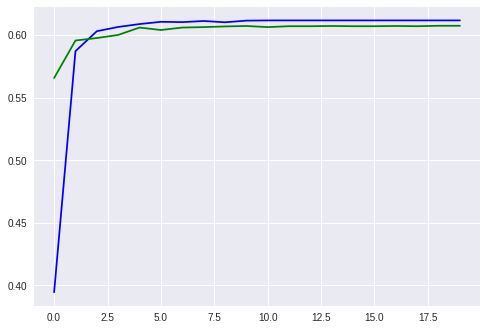

In [33]:
# Evaluate Model Accuracy
scores = model.evaluate(X_train, Y_train, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

# Visualize Model
plt.plot(history.history['acc'],'b') #train acc
plt.plot(history.history['val_acc'],'g') #val acc

__CNN with Sequential API:__  _Save_

We want so save this specific model off as a json, and weights to hdf5 for reusability purposes

In [34]:
# serialize model to JSON
model_json = model.to_json()
with open("sequential_cnn_model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("sequential_cnn_model.h5")
print("Saved model to disk")

Saved model to disk


---
## __Inception Module CNN with Functional API__

The <a href="https://keras.io/getting-started/functional-api-guide/">Functional API</a> allows much more flexibility than the Sequential API because you can create models that share layers or have multiple inputs or outputs. Models are then essentially the creation of layer instances and connecting them directly to each other in pairs. The steps usually include the definition of input based on the image data, connection of inception modules concluding with flattening and compiling the model. 

Functional API's have found that certain network structures work better than others. Specifically, Google created what is called the <a href="https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf">Inception Module</a>. This structure stacks inception layers to create a deep convolutional neural net, all the while controling for dimensionality reduction through the use of all filter types used all at once along with a pooling layer before output to the next inception occurs

Now, lets build the an inception module convolutional neural net model and see how it performs

__Inception Module CNN with Functional API:__ _Define Inception Module_

In [0]:
def inception(x, n = 32):
    p1 = Conv2D(n, 1, activation ='relu', padding='same')(x)
    
    p2 = Conv2D(n, 1, activation ='relu', padding='same')(x)
    p2 = Conv2D(n, 3, activation ='relu', padding='same')(p2)
    
    p3 = Conv2D(n, 1, activation ='relu', padding='same')(x)
    p3 = Conv2D(n, 5, activation ='relu', padding='same')(p3)
    
    p4 = MaxPooling2D((3,3), strides=(1, 1), padding='same')(x)
    p4 = Conv2D(n, 1, activation ='relu', padding='same')(p4)
    
    c =  Concatenate(axis=-1)([p1,p2,p3,p4])
    return c

__Inception Module CNN with Functional API:__ _Define Functional API Model_

In [0]:
def functional_cnn_model1():
    inputs = Input(X_train.shape[1:])
    i1 = inception(inputs)
    
    mp1 = MaxPooling2D((2,2))(i1)
    i2 = inception(mp1)
    
    mp2 = MaxPooling2D((2,2))(i2) 
    f = Flatten()(mp2)
    
    d = Dense(128, activation='relu')(f)
    out = Dense(10, activation='softmax')(d)
    model = Model(inputs, out)
    return model

__Inception Module CNN with Functional API:__ _Build_

Note the inception module's structure in that it enables a reduction of dimensionality to hopefully reduce noise, increase model speed and inrease worthwhile/transferrable accuracy.

In [20]:
# Build Model
model = functional_cnn_model1()

# View Model Summary
print(model.summary())

# Compile Model
model.compile(loss= 'categorical_crossentropy' , optimizer = 'adam' , metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 48, 32)   64          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 64, 48, 32)   64          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 48, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (

__Inception Module CNN with Functional API:__ _Run_

In [21]:
# Fit Model
t0=time.time()
history = model.fit(X_train, Y_train, validation_split = 0.25, epochs=15, batch_size=200, verbose=2)
t1=time.time()
print(t1-t0," seconds")

Train on 16818 samples, validate on 5606 samples
Epoch 1/15
 - 780s - loss: 1.9933 - acc: 0.3044 - val_loss: 1.3515 - val_acc: 0.5439
Epoch 2/15
 - 776s - loss: 0.6920 - acc: 0.7894 - val_loss: 0.3390 - val_acc: 0.9119
Epoch 3/15
 - 778s - loss: 0.1748 - acc: 0.9540 - val_loss: 0.1592 - val_acc: 0.9613
Epoch 4/15
 - 777s - loss: 0.0767 - acc: 0.9792 - val_loss: 0.0941 - val_acc: 0.9786
Epoch 5/15
 - 776s - loss: 0.0404 - acc: 0.9882 - val_loss: 0.1012 - val_acc: 0.9748
Epoch 6/15
 - 776s - loss: 0.0329 - acc: 0.9910 - val_loss: 0.0832 - val_acc: 0.9813
Epoch 7/15
 - 777s - loss: 0.0127 - acc: 0.9971 - val_loss: 0.0617 - val_acc: 0.9864
Epoch 8/15
 - 776s - loss: 0.0107 - acc: 0.9971 - val_loss: 0.0914 - val_acc: 0.9791
Epoch 9/15
 - 780s - loss: 0.0061 - acc: 0.9987 - val_loss: 0.0575 - val_acc: 0.9889
Epoch 10/15
 - 779s - loss: 0.0012 - acc: 0.9999 - val_loss: 0.0538 - val_acc: 0.9891
Epoch 11/15
 - 775s - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0902 - val_acc: 0.9814
Epoch 12/15
 -

__Inception Module CNN with Functional API:__ _Evaluate_

Looking really good, but overfitting a little. Lets see if we can improve by adding batch normalization. I think its fair to say that we will test both of functional api models against the testing dataset.

Baseline Error: 0.51%


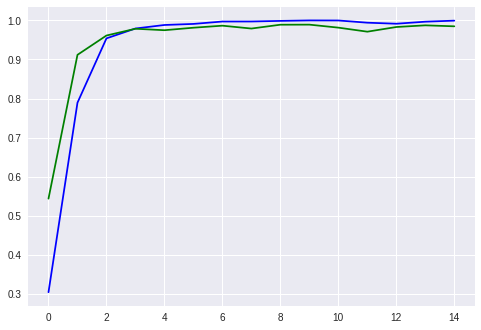

In [22]:
# Evaluate Model Accuracy
scores = model.evaluate(X_train, Y_train, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

# Visualize Model
plt.plot(history.history['acc'],'b') #train acc
plt.plot(history.history['val_acc'],'g') #val acc

__Inception CNN Modules with Functional API:__ _Save_

In [23]:
# serialize model to JSON
model_json = model.to_json()
with open("functional_cnn_model1.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("functional_cnn_model1.h5")
print("Saved model to disk")

Saved model to disk


__Inception Module CNN with Functional API:__ _Predict_

We will ingest the HDF5 data to predict how well the model performs in the competition, after prediction estimates we will manipulate the data to where it all fits nicely in a dataframe, then a csv for submission.

In [0]:
with h5py.File('testdata.hdf5','r') as f:
    X_Final_Test = f['X'][()] 

In [0]:
best_model_pred = model.predict(X_Final_Test)

In [0]:
pred_names = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']

pred_filenames_df = pd.read_csv("pred_filenames.csv")
pred_filenames = list(pred_filenames_df.iloc[:,1])


In [27]:
print("Length of filenames: " + str(len(pred_filenames)))
print("Length of simple_sequential_model_pred: " + str(best_model_pred.shape[0]))

Length of filenames: 79726
Length of simple_sequential_model_pred: 79726


In [28]:
best_model_pred_df = pd.DataFrame(best_model_pred, 
                                               index = pred_filenames, 
                                               columns = pred_names)

best_model_pred_df = best_model_pred_df.reset_index()
best_model_pred_df.rename(columns={'index': 'img'}, inplace=True)
best_model_pred_df.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,2.969293e-13,6.826481e-09,1.938540e-07,3.420098e-11,3.123956e-12,9.999993e-01,1.283151e-11,1.188116e-10,3.797234e-13,5.359357e-07
1,img_10.jpg,8.031030e-08,2.690666e-06,6.422636e-08,8.300275e-01,4.841516e-05,9.378550e-02,2.661294e-09,7.613263e-02,3.192020e-06,2.259026e-11
2,img_100.jpg,9.987236e-01,2.831646e-07,2.159854e-09,1.150157e-06,6.148370e-05,1.700687e-10,4.759057e-08,1.115440e-09,2.643904e-05,1.187109e-03
3,img_1000.jpg,2.936937e-02,2.108406e-05,1.783601e-03,1.092255e-06,8.697861e-01,1.882642e-08,9.709492e-02,2.934579e-08,1.943823e-03,8.174086e-11
4,img_100000.jpg,3.293543e-06,3.372787e-09,9.563728e-09,3.614487e-02,3.559760e-02,9.282525e-01,9.653728e-10,5.743759e-07,9.873531e-08,1.073328e-06


In [0]:
best_model_pred_df.to_csv('best_model_pred.csv', index=False, sep = ',')

__Inception Module CNN with Functional API:__ _Submission Results_

We submitted our most basic model with expected results. We rank fairly decent with a score of 4.4. I think that additional models with more complexity and controls for overfitting could be our best bet to improving the model significantly.

We can see below the overall probability sums by classification. Noting that the classification splits were pretty even, the model appears to have issues classifying c4 and c5, which is left hand on the phone and on the radio. 

In [30]:
best_model_pred_df[best_model_pred_df.columns[1:]].sum()

c0     8015.543457
c1     5260.963379
c2     5060.885254
c3     6218.187500
c4    13737.688477
c5    12204.382812
c6     5722.176758
c7     9634.083984
c8     9888.830078
c9     3979.662842
dtype: float32

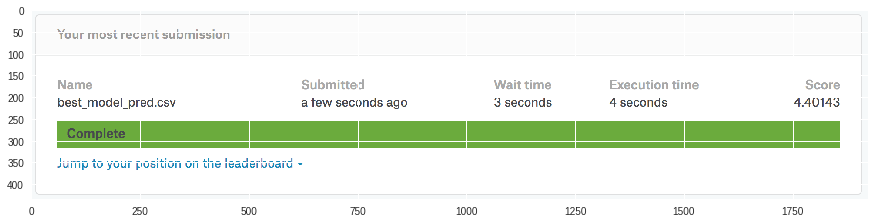

In [31]:
%matplotlib inline

RESULTS_simple_sequential_model_pred = Image.open('submission1.png')

plt.figure(figsize = (15,5))
plt.imshow(RESULTS_simple_sequential_model_pred)

__Inception Module CNN with Functional API:__ _Commentary and Concerns_

Ways to improve this model would be to attend to overfitting and increase the complexity of the model significantly. Many of my tuning pitfalls are around my inability to iterate more quickly because even when using Colaboratory, it takes over 3 hours to run even the simple inception model above. I will continue to create further iterations to improve my kaggle score, but those exploits may have to occur over a multi-day period.

Nevertheless, deep learning shows incredible accuracy on the training dataset and appears to scale relatively well to the testing dataset. Convolutional neural nets within a deep set of inception modules continues to prove its effectiveness at identifying image data.


---
## __Inception Module CNN with Functional API and Batch Normalization__

The addition of <a href="https://keras.io/layers/normalization/">Batch Normalization</a> in a deep neural net is that it provides normalization of data scale to add bias. This is one of the primary tools available within inception modeling to combat overfitting of the training data. I chose to explore this option further because of prior model's accuracy overfitting issues.

__Inception Module CNN with Functional API and Batch Normalization:__ _Define BN Inception Module_

In [0]:
def inception_b(x, n = 64):
    p1 = Conv2D(n, 1, padding='same')(x)
    p1 = BatchNormalization()(p1)
    p1 = Activation('relu')(p1)
    
    p2 = Conv2D(n, 1, padding='same')(x)
    p2 = BatchNormalization()(p2)
    p2 = Activation('relu')(p2)
    p2 = Conv2D(n, 3, padding='same')(p2)
    p2 = BatchNormalization()(p2)
    p2 = Activation('relu')(p2)    
    
    p3 = Conv2D(n, 1, padding='same')(x)
    p3 = BatchNormalization()(p3)
    p3 = Activation('relu')(p3)    
    p3 = Conv2D(n, 5, padding='same')(p3)
    p3 = BatchNormalization()(p3)
    p3 = Activation('relu')(p3)  
    
    p4 = MaxPooling2D((3,3), strides=(1, 1), padding='same')(x)    
    p4 = Conv2D(n, 1, padding='same')(p4)
    p4 = BatchNormalization()(p4)
    p4 = Activation('relu')(p4)     

    c =  Concatenate(axis=-1)([p1,p2,p3,p4])
    return c

__Inception Module CNN with Functional API and Batch Normalization:__ _Define BN Functional API_

In [0]:
def functional_cnn_model2():
    inputs = Input(X_train.shape[1:])
    i1 = inception_b(inputs)
    
    mp1 = MaxPooling2D((2,2))(i1)
    i2 = inception_b(mp1)
    
    mp2 = MaxPooling2D((2,2))(i2) 
    f = Flatten()(mp2)
    d = Dense(128)(f)
    d = BatchNormalization()(d)
    d = Activation('relu')(d)
    out = Dense(10, activation='softmax')(d)
    model = Model(inputs, out)
    return model

__Inception Module CNN with Functional API and Batch Normalization:__ _Build_

In [0]:
# Build Model
model_f = functional_cnn_model1()

# View Model Summary
print(model_f.summary())

# Edit Optimizer to Learn More Slowly
adam = optimizers.Adam(lr=0.001)

# Compile Model
model_f.compile(loss= 'categorical_crossentropy' , optimizer = adam , metrics=['accuracy'])

__Inception Module CNN with Functional API and Batch Normalization:__ _Run_

In [0]:
# Fit Model
t0=time.time()
history = model_f.fit(X_train, Y_train, validation_split = 0.25, epochs=30, batch_size=200, verbose=2)
t1=time.time()
print(t1-t0," seconds")

__Inception Module CNN with Functional API and Batch Normalization:__ _Evaluate_

In [0]:
# Evaluate Model Accuracy
scores = model_f.evaluate(X_train, Y_train, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

# Visualize Model
plt.plot(history.history['acc'],'b') #train acc
plt.plot(history.history['val_acc'],'g') #val acc

__Inception Module CNN with Functional API and Batch Normalization:__ _Save_



In [0]:
# serialize model to JSON
model_json = model_f.to_json()
with open("functional_cnn_model2.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model_f.save_weights("functional_cnn_model2.h5")
print("Saved model to disk")

__Inception Module CNN with Functional API and Batch Normalization:__ _Predict_


In [0]:
best_model_pred2 = model_f.predict(X_Final_Test)

In [0]:
print("Length of filenames: " + str(len(pred_filenames)))
print("Length of simple_sequential_model_pred: " + str(best_model_pred2.shape[0]))

Length of filenames: 79726
Length of simple_sequential_model_pred: 79726


__Below is highlighting that something is screwy with my classification__

In [0]:
best_model_pred2_df = pd.DataFrame(best_model_pred2, 
                                               index = pred_filenames, 
                                               columns = pred_names)

best_model_pred2_df = best_model_pred2_df.reset_index()
best_model_pred2_df.rename(columns={'index': 'img'}, inplace=True)
best_model_pred2_df.head()

In [0]:
best_model_pred2_df.to_csv('best_model_pred2.csv', index=False, sep = ',')

__Basic CNN Sequential Model:__ _Submission Results_

We submitted our most basic model with expected results

In [0]:
best_model_pred2_df[best_model_pred2_df.columns[1:]].sum()

In [0]:
#%matplotlib inline

#RESULTS_simple_sequential_model_pred = Image.open('RESULTS_simple_sequential_model_pred.png')

#plt.figure(figsize = (15,5))
#plt.imshow(RESULTS_simple_sequential_model_pred)